In [1]:
"""
This file replicates the querying process of IVF_PQ index on sift1B dataset 
It also provides function that can retrieve the PQ code of each 
Voronoi cells, the coarse grained cluster centroids, and the
sub-quantizer centroids
"""

'\nThis file replicates the querying process of IVF_PQ index on sift1B dataset \nIt also provides function that can retrieve the PQ code of each \nVoronoi cells, the coarse grained cluster centroids, and the\nsub-quantizer centroids\n'

In [1]:
from __future__ import print_function
import os
import sys
import time
import numpy as np
import re
import faiss
from multiprocessing.dummy import Pool as ThreadPool
from matplotlib import pyplot

save_data = False

In [2]:
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]


def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]

def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

dbname        = 'SIFT1000M'
index_key     = 'IVF8192,PQ16'
parametersets = ['nprobe=1', 'nprobe=32']


tmpdir = '../trained_CPU_indexes/bench_cpu_{}_{}'.format(dbname, index_key)

if not os.path.isdir(tmpdir):
    raise("%s does not exist")


#################################################################
# Prepare dataset
#################################################################


print("Preparing dataset", dbname)

if dbname.startswith('SIFT'):
    # SIFT1M to SIFT1000M
    dbsize = int(dbname[4:-1])
    xb = mmap_bvecs('../bigann/bigann_base.bvecs')
    xq = mmap_bvecs('../bigann/bigann_query.bvecs')
    xt = mmap_bvecs('../bigann/bigann_learn.bvecs')

    # trim xb to correct size
    xb = xb[:dbsize * 1000 * 1000]

    gt = ivecs_read('../bigann/gnd/idx_%dM.ivecs' % dbsize)

elif dbname == 'Deep1B':
    xb = mmap_fvecs('../deep1b/base.fvecs')
    xq = mmap_fvecs('../deep1b/deep1B_queries.fvecs')
    xt = mmap_fvecs('../deep1b/learn.fvecs')
    # deep1B's train is is outrageously big
    xt = xt[:10 * 1000 * 1000]
    gt = ivecs_read('../deep1b/deep1B_groundtruth.ivecs')

else:
    print('unknown dataset', dbname, file=sys.stderr)
    sys.exit(1)


print("sizes: B %s Q %s T %s gt %s" % (
    xb.shape, xq.shape, xt.shape, gt.shape))

nq, d = xq.shape
nb, d = xb.shape
assert gt.shape[0] == nq


#################################################################
# Load Index
#################################################################

def get_populated_index():

    filename = "%s/%s_%s_populated.index" % (
        tmpdir, dbname, index_key)

    if not os.path.exists(filename):
        raise("Index does not exist!")
    else:
        print("loading", filename)
        index = faiss.read_index(filename)
    return index


Preparing dataset SIFT1000M
sizes: B (1000000000, 128) Q (10000, 128) T (100000000, 128) gt (10000, 1000)


In [3]:
# xb -> all full precision vectors in database (1B)
# xq -> all full precision query vectors in database (10K)
# xq -> all full precision learning set vectors in database (100M)
# gt -> ground truth of topk=1000 (10K)
print(type(xb))

<class 'numpy.memmap'>


In [4]:
"""
The index object already includes the coarse-grained centroids, and sub-quantizers

-rw-r--r--  1 wejiang wejiang-group     4325556 Oct 11 22:07 SIFT1000M_IVF8192,PQ16_trained.index -> coarse-grained
-rw-r--r--  1 wejiang wejiang-group 24004391092 Oct 12 00:07 SIFT1000M_IVF8192,PQ16_populated.index -> all
"""

'\nThe index object already includes the coarse-grained centroids, and sub-quantizers\n\n-rw-r--r--  1 wejiang wejiang-group     4325556 Oct 11 22:07 SIFT1000M_IVF8192,PQ16_trained.index -> coarse-grained\n-rw-r--r--  1 wejiang wejiang-group 24004391092 Oct 12 00:07 SIFT1000M_IVF8192,PQ16_populated.index -> all\n'

In [5]:
#################################################################
# Perform searches
#################################################################

index = get_populated_index()

ps = faiss.ParameterSpace()
ps.initialize(index)

# make sure queries are in RAM
xq = xq.astype('float32').copy()

# a static C++ object that collects statistics about searches
ivfpq_stats = faiss.cvar.indexIVFPQ_stats
ivf_stats = faiss.cvar.indexIVF_stats


# we do queries in a single thread
faiss.omp_set_num_threads(1)

print(' ' * len(parametersets[0]), '\t', 'R@1    R@10   R@100     time    %pass')

for param in parametersets:
    print(param, '\t', end=' ')
    sys.stdout.flush()
    ps.set_index_parameters(index, param)
    t0 = time.time()
    ivfpq_stats.reset()
    ivf_stats.reset()
    D, I = index.search(xq, 100)
    t1 = time.time()
    for rank in 1, 10, 100:
        n_ok = (I[:, :rank] == gt[:, :1]).sum()
        print("%.4f" % (n_ok / float(nq)), end=' ')
    print("%8.3f  " % ((t1 - t0) * 1000.0 / nq), end=' ')
    print("%5.2f" % (ivfpq_stats.n_hamming_pass * 100.0 / ivf_stats.ndis))

loading ../trained_CPU_indexes/bench_cpu_SIFT1000M_IVF8192,PQ16/SIFT1000M_IVF8192,PQ16_populated.index
         	 R@1    R@10   R@100     time    %pass
nprobe=1 	 0.1934 0.3964 0.4482    1.465    0.00
nprobe=32 	 0.2857 0.7326 0.9568   42.976    0.00


In [6]:
print("==== Distance ====\n\n{}\nshape: {}\n".format(D, D.shape))
print("==== Index ====\n\n{}\nshape: {}\n".format(I, I.shape))

==== Distance ====

[[50993.203 54336.414 56335.76  ... 65039.16  65092.453 65136.562]
 [28778.004 29403.02  29605.914 ... 38942.62  38943.63  38955.61 ]
 [35337.684 35693.312 35995.484 ... 43081.79  43117.96  43128.875]
 ...
 [47332.293 48143.83  49028.484 ... 58328.45  58379.38  58422.836]
 [38902.82  39315.617 41596.766 ... 53518.285 53519.25  53557.53 ]
 [37481.633 39034.703 39707.74  ... 52359.676 52385.773 52396.105]]
shape: (10000, 100)

==== Index ====

[[672303393 615142927 204071725 ... 905142920 277061603 603696095]
 [328569870 455604845 337592366 ... 356877104  25276549 721982882]
 [397763200 207300893 924963237 ... 447729961 522492180 827586288]
 ...
 [261386442 423027881 456076419 ... 134056270  68733067 505049966]
 [443633952 433375204 935973620 ... 112122141 847878828 241995425]
 [193715219 266287267 883319926 ... 493087999 625182027 918522722]]
shape: (10000, 100)



In [7]:
print("Query vector example\nxq\ttype: {}\tshape: {}\n".format(type(xq), xq.shape))
print(xq[0], xq[0].shape) 
# Why like integers? -> The sift1b dataset actually stores vector in uint8 format, to save space
#   size = 132000000000 bytes = (128 bytes vector + 4 bytes index) * 1B
print(xq[0][0])

Query vector example
xq	type: <class 'numpy.memmap'>	shape: (10000, 128)

[  3.   9.  17.  78.  83.  15.  10.   8. 101. 109.  21.   8.   3.   2.
   9.  64.  39.  31.  18.  80.  55.  10.   2.  12.   7.   7.  26.  58.
  32.   6.   4.   3.  14.   2.  13.  28.  37.  19.  47.  59. 109.  22.
   2.   6.  18.  15.  20. 109.  30.   8.  11.  44. 109.  54.  19.  32.
  17.  21.  15.  22.  12.  28. 101.  35.  66.  11.   9.  30.  68.  35.
  30.  75. 106. 103.  26.  50.  76.  20.   8.  13.  51.  41.  63. 109.
  40.   2.   3.  15.  36.  49.  21.  13.  12.   9.  36.  37.  52.  37.
  24.  34.  19.   3.  13.  23.  21.   8.   3.  20.  68.  56.  79.  60.
  99.  36.   7.  28.  78.  41.   7.  21.  74.  26.   3.  15.  34.  15.
  12.  27.] (128,)
3.0


In [8]:
"""NOTE! Don't run this unless you want to save them to npy"""
if save_data == True:
    D = np.array(D, dtype=np.float32)
    I = np.array(I, dtype=np.int32)
    xq = np.array(xq, dtype=np.float32)
    print(D.shape, I.shape, xq.shape)
    D.tofile("./saved_npy_data/result_distance_float32_10000_100_raw")
    I.tofile("./saved_npy_data/result_index_int32_10000_100_raw")
    xq.tofile("./saved_npy_data/query_vectors_float32_10000_128_raw")

In [9]:
single_q = xq[0].reshape(1, -1)
dist, idx = index.search(single_q, 100)

In [10]:
print("==== Index ====\n\n{}\n".format(idx))
print("==== Distance ====\n\n{}\n".format(dist))

==== Index ====

[[672303393 615142927 204071725 971823307 201892784 937541801 722477532
  336118969 245885573 740285375 656556888 968173533 110973576 277259885
  290543557 203588195 544978851 614757093 904249396 207753439 458731394
  267986685 880358133 123365395 725237737 221456167 383328762 351655146
  862245159 634040555 668882806 744707409 718496051 203398697 956349545
  879095196 674980795 356698977 657676309 920763800 168233858 470132504
  366729519 255829277 339763325 250663892  40642738 722321159 791883084
  694293478  28539420 302873886 794816190 481248571 351657336 221457391
  822165807 681475806 579811330 716055137 704361214 477723287 922453899
  178577649 837625153 502889241 776920366 648108651 591351597 558889020
  876033653  40156538 224060326  71522777 956646244 148931760  31464083
  221456488 261944447 219498491 372047056 731202344 536916168 459020955
  944547995 991250886 219151745 833801070 785731029 207488404 768782587
  221457012 879095218 468300062 967679308 62201

In [11]:
coarse_quantizer = faiss.downcast_index(index.quantizer)
# coarse_cen = faiss.vector_to_array(coarse_quantizer.xb)
# print(coarse_cen.shape)

In [15]:
dir(index)

['PARALLEL_MODE_NO_HEAP_INIT',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__swig_getmethods__',
 '__swig_setmethods__',
 '__weakref__',
 '_s',
 'add',
 'add_c',
 'add_core_o',
 'add_with_ids',
 'add_with_ids_c',
 'assign',
 'assign_c',
 'by_residual',
 'check_compatible_for_merge',
 'clustering_index',
 'coarse_code_size',
 'code_size',
 'compute_residual',
 'compute_residual_n',
 'copy_subset_to',
 'cp',
 'd',
 'decode_listno',
 'decode_multiple',
 'direct_map',
 'do_polysemous_training',
 'encode',
 'encode_listno',
 'encode_multiple',
 'encode_vectors',
 'find_duplicates',
 'get_InvertedListScanner',
 'get_distance_computer',
 

In [12]:
"""
My Search Functions
"""

def get_sub_quantizer_centroids(index):
    """
    return the sub-quantizer centroids, 
    shape = (m, 256, d / m)
    e.g., d=128, m=16 -> (16, 256, 8)
    """
    pq = index.pq
    cen = faiss.vector_to_array(pq.centroids)
    cen = cen.reshape(pq.M, pq.ksub, pq.dsub)
    
    return cen

def get_coarse_quantizer_centroids(coarse_quantizer):
    """
    return the coarse-grained quantizer centroids,
    shape = (nlist, d),
    e.g., nlist=1024, d=128 -> (1024, 128)
    """
    coarse_cen = faiss.vector_to_array(coarse_quantizer.xb)
#     print("coarse_cen.shape", coarse_cen.shape) # 1024 * 64 = 65536
#     print("coarse_quantizer.ntotal", coarse_quantizer.ntotal)
#     print("coarse_quantizer.d", coarse_quantizer.d)

    coarse_cen = coarse_cen.reshape(coarse_quantizer.ntotal, coarse_quantizer.d)
    return coarse_cen

In [13]:
# Get Sub quantizer info
sub_cen = get_sub_quantizer_centroids(index)
print("==== Sub-quantizer ====\n{}\n\nshape:{}\n".format(sub_cen, sub_cen.shape))

# Get Coarse quantizer info
coarse_cen = get_coarse_quantizer_centroids(coarse_quantizer)
print("==== Coarse-quantizer ====\n{}\n\nshape:{}\n".format(coarse_cen, coarse_cen.shape))

==== Sub-quantizer ====
[[[-1.39830580e+01 -9.50784492e+00 -3.96348667e+00 ...  5.86917877e+00
    1.04514023e+02  1.04102793e+01]
  [-6.90511627e+01 -2.03367958e+01  2.62607670e+00 ...  2.83390975e+00
    1.95819175e+00 -8.36786938e+00]
  [-4.25987320e+01 -9.93877316e+00  1.04937162e+01 ... -1.98086727e+00
   -6.30460835e+00 -2.12152977e+01]
  ...
  [ 1.92724438e+01  2.98870945e+00 -6.91194391e+00 ...  1.94331989e+01
   -9.75370109e-01 -8.94906640e-01]
  [ 2.05092468e+01 -1.09992886e+00 -9.42241001e+00 ...  9.38970661e+00
   -7.21518993e+00 -4.89512920e+00]
  [ 1.51460276e+01  1.51528549e+00 -1.98966455e+00 ... -1.96080756e+00
   -1.24802208e+00  4.54244643e-01]]

 [[-1.38893576e+01 -1.30567741e+01  1.27895641e+01 ... -1.25062037e+00
    4.34972916e+01  7.75580406e+00]
  [ 1.04570885e+01  3.74349747e+01  1.84257901e+00 ... -4.78825521e+00
    1.15119820e+01  5.44087677e+01]
  [-1.12493572e+01 -3.95343399e+00  1.05285339e+01 ... -1.15094595e+01
   -1.70058894e+00 -4.81053877e+00]
  ...

In [21]:
"""NOTE! Don't run this unless you want to save them to npy"""
if save_data == True:
    PQ_quantizer = np.array(sub_cen, dtype=np.float32)
    coarse_cen = np.array(coarse_cen, dtype=np.float32)
    print(PQ_quantizer.shape, coarse_cen.shape)
    PQ_quantizer.tofile("./saved_npy_data/PQ_quantizer_float32_16_256_8_raw")
    coarse_cen.tofile("./saved_npy_data/coarse_centers_float32_8192_128_raw")

(16, 256, 8) (8192, 128)


In [2]:
invlists = index.invlists


def get_invlist(invlists, l):
    """ 
    returns the (vector IDs set, PQ cose set) of list ID "l"
    list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
    list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)
    
    That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
    To avoid this, just clone the output arrays on output. 
    """
    ls = invlists.list_size(l)
    list_vec_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
    list_PQ_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
    list_PQ_codes = list_PQ_codes.reshape(-1, invlists.code_size)
    return list_vec_ids, list_PQ_codes

NameError: name 'index' is not defined

In [23]:
# Example of using function "get_invlist"
list_id = 124
list_vec_ids, list_PQ_codes = get_invlist(invlists, list_id)
print("==== Vector IDs ====\n{}\n\nshape: {}\n".format(list_vec_ids, list_vec_ids.shape))
print("==== PQ codes ====\n{}\n\nshape: {}\n".format(list_PQ_codes, list_PQ_codes.shape))

==== Vector IDs ====
[     7330     15876     19023 ... 999967925 999970701 999994567]

shape: (81713,)

==== PQ codes ====
[[232 237  49 ...  65 119  71]
 [ 49   0 156 ... 169  13  25]
 [169 193 103 ...  53 252 104]
 ...
 [234 237 225 ... 142 209 251]
 [234 157 140 ...  85  57 218]
 [147   2 146 ...  37  71 118]]

shape: (81713, 16)



In [ ]:
"""NOTE! Don't run this unless you want to save them to npy"""
if save_data == True:
    for list_id in range(8192):
        list_ids, list_codes = get_invlist(invlists, list_id)
        list_ids = np.array(list_ids, dtype=np.int32)
        list_codes = np.array(list_codes, dtype=np.uint8)
        print("list {}: {} {}".format(list_id, list_ids.shape, list_codes.shape))
        list_ids.tofile("./saved_npy_data/cells/list_{}_IDs_int32_{}_raw".format(list_id, list_ids.shape[0]))
        list_codes.tofile("./saved_npy_data/cells/list_{}_codes_uint8_{}_16_raw".format(list_id, list_codes.shape[0]))

list 0: (97891,) (97891, 16)
list 1: (131444,) (131444, 16)
list 2: (88340,) (88340, 16)
list 3: (150337,) (150337, 16)
list 4: (151644,) (151644, 16)
list 5: (62815,) (62815, 16)
list 6: (132598,) (132598, 16)
list 7: (109618,) (109618, 16)
list 8: (160801,) (160801, 16)
list 9: (117041,) (117041, 16)
list 10: (131892,) (131892, 16)
list 11: (27735,) (27735, 16)
list 12: (97129,) (97129, 16)
list 13: (112825,) (112825, 16)
list 14: (126305,) (126305, 16)
list 15: (97689,) (97689, 16)
list 16: (129619,) (129619, 16)
list 17: (100538,) (100538, 16)
list 18: (130981,) (130981, 16)
list 19: (97774,) (97774, 16)
list 20: (100708,) (100708, 16)
list 21: (120141,) (120141, 16)
list 22: (56656,) (56656, 16)
list 23: (83746,) (83746, 16)
list 24: (100999,) (100999, 16)
list 25: (199867,) (199867, 16)
list 26: (148545,) (148545, 16)
list 27: (85500,) (85500, 16)
list 28: (115134,) (115134, 16)
list 29: (95470,) (95470, 16)
list 30: (117393,) (117393, 16)
list 31: (99850,) (99850, 16)
list 32: (

list 266: (155156,) (155156, 16)
list 267: (138276,) (138276, 16)
list 268: (179661,) (179661, 16)
list 269: (115346,) (115346, 16)
list 270: (83533,) (83533, 16)
list 271: (112589,) (112589, 16)
list 272: (128117,) (128117, 16)
list 273: (138035,) (138035, 16)
list 274: (136769,) (136769, 16)
list 275: (91254,) (91254, 16)
list 276: (117302,) (117302, 16)
list 277: (85683,) (85683, 16)
list 278: (89165,) (89165, 16)
list 279: (98988,) (98988, 16)
list 280: (97178,) (97178, 16)
list 281: (108921,) (108921, 16)
list 282: (66895,) (66895, 16)
list 283: (92482,) (92482, 16)
list 284: (150632,) (150632, 16)
list 285: (101507,) (101507, 16)
list 286: (97314,) (97314, 16)
list 287: (154300,) (154300, 16)
list 288: (107978,) (107978, 16)
list 289: (120177,) (120177, 16)
list 290: (111812,) (111812, 16)
list 291: (91863,) (91863, 16)
list 292: (107949,) (107949, 16)
list 293: (152729,) (152729, 16)
list 294: (103489,) (103489, 16)
list 295: (110056,) (110056, 16)
list 296: (144827,) (144827, 1

list 526: (138145,) (138145, 16)
list 527: (121978,) (121978, 16)
list 528: (158116,) (158116, 16)
list 529: (76429,) (76429, 16)
list 530: (110104,) (110104, 16)
list 531: (121481,) (121481, 16)
list 532: (91478,) (91478, 16)
list 533: (131488,) (131488, 16)
list 534: (174680,) (174680, 16)
list 535: (104441,) (104441, 16)
list 536: (113058,) (113058, 16)
list 537: (140105,) (140105, 16)
list 538: (92857,) (92857, 16)
list 539: (125058,) (125058, 16)
list 540: (117572,) (117572, 16)
list 541: (99517,) (99517, 16)
list 542: (121611,) (121611, 16)
list 543: (86008,) (86008, 16)
list 544: (82947,) (82947, 16)
list 545: (165727,) (165727, 16)
list 546: (272955,) (272955, 16)
list 547: (106851,) (106851, 16)
list 548: (92459,) (92459, 16)
list 549: (111150,) (111150, 16)
list 550: (129695,) (129695, 16)
list 551: (108237,) (108237, 16)
list 552: (197273,) (197273, 16)
list 553: (108536,) (108536, 16)
list 554: (90346,) (90346, 16)
list 555: (133044,) (133044, 16)
list 556: (144827,) (14482

list 781: (122197,) (122197, 16)
list 782: (111151,) (111151, 16)
list 783: (126341,) (126341, 16)
list 784: (144809,) (144809, 16)
list 785: (139280,) (139280, 16)
list 786: (131706,) (131706, 16)
list 787: (211184,) (211184, 16)
list 788: (123830,) (123830, 16)
list 789: (147572,) (147572, 16)
list 790: (83483,) (83483, 16)
list 791: (118675,) (118675, 16)
list 792: (163524,) (163524, 16)
list 793: (124105,) (124105, 16)
list 794: (17636,) (17636, 16)
list 795: (54189,) (54189, 16)
list 796: (107724,) (107724, 16)
list 797: (94807,) (94807, 16)
list 798: (92698,) (92698, 16)
list 799: (152487,) (152487, 16)
list 800: (157023,) (157023, 16)
list 801: (105922,) (105922, 16)
list 802: (119758,) (119758, 16)
list 803: (89563,) (89563, 16)
list 804: (121456,) (121456, 16)
list 805: (150015,) (150015, 16)
list 806: (145998,) (145998, 16)
list 807: (92100,) (92100, 16)
list 808: (96364,) (96364, 16)
list 809: (121748,) (121748, 16)
list 810: (111936,) (111936, 16)
list 811: (98721,) (98721,

list 1035: (185075,) (185075, 16)
list 1036: (133013,) (133013, 16)
list 1037: (145891,) (145891, 16)
list 1038: (151605,) (151605, 16)
list 1039: (86963,) (86963, 16)
list 1040: (211322,) (211322, 16)
list 1041: (129106,) (129106, 16)
list 1042: (80558,) (80558, 16)
list 1043: (84911,) (84911, 16)
list 1044: (103242,) (103242, 16)
list 1045: (94845,) (94845, 16)
list 1046: (86925,) (86925, 16)
list 1047: (77091,) (77091, 16)
list 1048: (93512,) (93512, 16)
list 1049: (86282,) (86282, 16)
list 1050: (161301,) (161301, 16)
list 1051: (94140,) (94140, 16)
list 1052: (126542,) (126542, 16)
list 1053: (104655,) (104655, 16)
list 1054: (103125,) (103125, 16)
list 1055: (170573,) (170573, 16)
list 1056: (103160,) (103160, 16)
list 1057: (166345,) (166345, 16)
list 1058: (100736,) (100736, 16)
list 1059: (36503,) (36503, 16)
list 1060: (219661,) (219661, 16)
list 1061: (350018,) (350018, 16)
list 1062: (130565,) (130565, 16)
list 1063: (123738,) (123738, 16)
list 1064: (89274,) (89274, 16)
li

list 1283: (111746,) (111746, 16)
list 1284: (188163,) (188163, 16)
list 1285: (98209,) (98209, 16)
list 1286: (150087,) (150087, 16)
list 1287: (256057,) (256057, 16)
list 1288: (53289,) (53289, 16)
list 1289: (81484,) (81484, 16)
list 1290: (64252,) (64252, 16)
list 1291: (123683,) (123683, 16)
list 1292: (152838,) (152838, 16)
list 1293: (109717,) (109717, 16)
list 1294: (121908,) (121908, 16)
list 1295: (108547,) (108547, 16)
list 1296: (97330,) (97330, 16)
list 1297: (149505,) (149505, 16)
list 1298: (88530,) (88530, 16)
list 1299: (152371,) (152371, 16)
list 1300: (101534,) (101534, 16)
list 1301: (65368,) (65368, 16)
list 1302: (99363,) (99363, 16)
list 1303: (133571,) (133571, 16)
list 1304: (11934,) (11934, 16)
list 1305: (126866,) (126866, 16)
list 1306: (318110,) (318110, 16)
list 1307: (101055,) (101055, 16)
list 1308: (125688,) (125688, 16)
list 1309: (229708,) (229708, 16)
list 1310: (117453,) (117453, 16)
list 1311: (117494,) (117494, 16)
list 1312: (109353,) (109353, 16

list 1538: (107284,) (107284, 16)
list 1539: (222552,) (222552, 16)
list 1540: (98989,) (98989, 16)
list 1541: (94288,) (94288, 16)
list 1542: (78347,) (78347, 16)
list 1543: (190128,) (190128, 16)
list 1544: (139339,) (139339, 16)
list 1545: (129154,) (129154, 16)
list 1546: (137012,) (137012, 16)
list 1547: (98586,) (98586, 16)
list 1548: (117059,) (117059, 16)
list 1549: (71417,) (71417, 16)
list 1550: (199566,) (199566, 16)
list 1551: (138038,) (138038, 16)
list 1552: (140681,) (140681, 16)
list 1553: (83777,) (83777, 16)
list 1554: (115876,) (115876, 16)
list 1555: (120045,) (120045, 16)
list 1556: (65459,) (65459, 16)
list 1557: (102616,) (102616, 16)
list 1558: (111104,) (111104, 16)
list 1559: (83936,) (83936, 16)
list 1560: (148973,) (148973, 16)
list 1561: (103337,) (103337, 16)
list 1562: (110642,) (110642, 16)
list 1563: (134188,) (134188, 16)
list 1564: (126808,) (126808, 16)
list 1565: (145150,) (145150, 16)
list 1566: (117734,) (117734, 16)
list 1567: (133379,) (133379, 

list 1793: (173663,) (173663, 16)
list 1794: (133537,) (133537, 16)
list 1795: (103750,) (103750, 16)
list 1796: (81941,) (81941, 16)
list 1797: (117245,) (117245, 16)
list 1798: (43590,) (43590, 16)
list 1799: (151762,) (151762, 16)
list 1800: (58110,) (58110, 16)
list 1801: (100776,) (100776, 16)
list 1802: (159396,) (159396, 16)
list 1803: (119226,) (119226, 16)
list 1804: (110095,) (110095, 16)
list 1805: (146370,) (146370, 16)
list 1806: (131359,) (131359, 16)
list 1807: (121051,) (121051, 16)
list 1808: (113647,) (113647, 16)
list 1809: (127174,) (127174, 16)
list 1810: (121123,) (121123, 16)
list 1811: (231620,) (231620, 16)
list 1812: (123821,) (123821, 16)
list 1813: (89779,) (89779, 16)
list 1814: (90301,) (90301, 16)
list 1815: (64022,) (64022, 16)
list 1816: (141901,) (141901, 16)
list 1817: (76347,) (76347, 16)
list 1818: (121022,) (121022, 16)
list 1819: (108626,) (108626, 16)
list 1820: (145196,) (145196, 16)
list 1821: (102471,) (102471, 16)
list 1822: (137387,) (137387

list 2047: (114462,) (114462, 16)
list 2048: (132869,) (132869, 16)
list 2049: (93805,) (93805, 16)
list 2050: (113205,) (113205, 16)
list 2051: (76275,) (76275, 16)
list 2052: (130651,) (130651, 16)
list 2053: (111656,) (111656, 16)
list 2054: (148622,) (148622, 16)
list 2055: (92136,) (92136, 16)
list 2056: (119137,) (119137, 16)
list 2057: (118743,) (118743, 16)
list 2058: (98580,) (98580, 16)
list 2059: (130309,) (130309, 16)
list 2060: (88604,) (88604, 16)
list 2061: (130682,) (130682, 16)
list 2062: (102045,) (102045, 16)
list 2063: (187800,) (187800, 16)
list 2064: (152520,) (152520, 16)
list 2065: (168189,) (168189, 16)
list 2066: (129885,) (129885, 16)
list 2067: (120187,) (120187, 16)
list 2068: (90436,) (90436, 16)
list 2069: (134968,) (134968, 16)
list 2070: (96642,) (96642, 16)
list 2071: (100516,) (100516, 16)
list 2072: (82480,) (82480, 16)
list 2073: (108287,) (108287, 16)
list 2074: (83775,) (83775, 16)
list 2075: (125580,) (125580, 16)
list 2076: (100912,) (100912, 16

list 2299: (96197,) (96197, 16)
list 2300: (108819,) (108819, 16)
list 2301: (154922,) (154922, 16)
list 2302: (116414,) (116414, 16)
list 2303: (126763,) (126763, 16)
list 2304: (122938,) (122938, 16)
list 2305: (129668,) (129668, 16)
list 2306: (92319,) (92319, 16)
list 2307: (125465,) (125465, 16)
list 2308: (99091,) (99091, 16)
list 2309: (265275,) (265275, 16)
list 2310: (111593,) (111593, 16)
list 2311: (121146,) (121146, 16)
list 2312: (99530,) (99530, 16)
list 2313: (125437,) (125437, 16)
list 2314: (144939,) (144939, 16)
list 2315: (133618,) (133618, 16)
list 2316: (110881,) (110881, 16)
list 2317: (276007,) (276007, 16)
list 2318: (76163,) (76163, 16)
list 2319: (81577,) (81577, 16)
list 2320: (97121,) (97121, 16)
list 2321: (79450,) (79450, 16)
list 2322: (92850,) (92850, 16)
list 2323: (228780,) (228780, 16)
list 2324: (86922,) (86922, 16)
list 2325: (121338,) (121338, 16)
list 2326: (81591,) (81591, 16)
list 2327: (88176,) (88176, 16)
list 2328: (183671,) (183671, 16)
list

list 2551: (131501,) (131501, 16)
list 2552: (100672,) (100672, 16)
list 2553: (136733,) (136733, 16)
list 2554: (245289,) (245289, 16)
list 2555: (53179,) (53179, 16)
list 2556: (118974,) (118974, 16)
list 2557: (111113,) (111113, 16)
list 2558: (89282,) (89282, 16)
list 2559: (129308,) (129308, 16)
list 2560: (88955,) (88955, 16)
list 2561: (158807,) (158807, 16)
list 2562: (61680,) (61680, 16)
list 2563: (123052,) (123052, 16)
list 2564: (145600,) (145600, 16)
list 2565: (187531,) (187531, 16)
list 2566: (119748,) (119748, 16)
list 2567: (176164,) (176164, 16)
list 2568: (93264,) (93264, 16)
list 2569: (66623,) (66623, 16)
list 2570: (177367,) (177367, 16)
list 2571: (171221,) (171221, 16)
list 2572: (143051,) (143051, 16)
list 2573: (89277,) (89277, 16)
list 2574: (193235,) (193235, 16)
list 2575: (92406,) (92406, 16)
list 2576: (123429,) (123429, 16)
list 2577: (194916,) (194916, 16)
list 2578: (83161,) (83161, 16)
list 2579: (115633,) (115633, 16)
list 2580: (92273,) (92273, 16)


list 2805: (88673,) (88673, 16)
list 2806: (166648,) (166648, 16)
list 2807: (160975,) (160975, 16)
list 2808: (106734,) (106734, 16)
list 2809: (115381,) (115381, 16)
list 2810: (150000,) (150000, 16)
list 2811: (92600,) (92600, 16)
list 2812: (123837,) (123837, 16)
list 2813: (97053,) (97053, 16)
list 2814: (139295,) (139295, 16)
list 2815: (106496,) (106496, 16)
list 2816: (98413,) (98413, 16)
list 2817: (80338,) (80338, 16)
list 2818: (96120,) (96120, 16)
list 2819: (109976,) (109976, 16)
list 2820: (96262,) (96262, 16)
list 2821: (96178,) (96178, 16)
list 2822: (84273,) (84273, 16)
list 2823: (150871,) (150871, 16)
list 2824: (80661,) (80661, 16)
list 2825: (196012,) (196012, 16)
list 2826: (115626,) (115626, 16)
list 2827: (135744,) (135744, 16)
list 2828: (115171,) (115171, 16)
list 2829: (171258,) (171258, 16)
list 2830: (90448,) (90448, 16)
list 2831: (81878,) (81878, 16)
list 2832: (118882,) (118882, 16)
list 2833: (147280,) (147280, 16)
list 2834: (119641,) (119641, 16)
list

list 3056: (103272,) (103272, 16)
list 3057: (143282,) (143282, 16)
list 3058: (113903,) (113903, 16)
list 3059: (119009,) (119009, 16)
list 3060: (18649,) (18649, 16)
list 3061: (104566,) (104566, 16)
list 3062: (135541,) (135541, 16)
list 3063: (205959,) (205959, 16)
list 3064: (101053,) (101053, 16)
list 3065: (199042,) (199042, 16)
list 3066: (87831,) (87831, 16)
list 3067: (114148,) (114148, 16)
list 3068: (76918,) (76918, 16)
list 3069: (91015,) (91015, 16)
list 3070: (104023,) (104023, 16)
list 3071: (91681,) (91681, 16)
list 3072: (149843,) (149843, 16)
list 3073: (160580,) (160580, 16)
list 3074: (98962,) (98962, 16)
list 3075: (135075,) (135075, 16)
list 3076: (166356,) (166356, 16)
list 3077: (125478,) (125478, 16)
list 3078: (314647,) (314647, 16)
list 3079: (109440,) (109440, 16)
list 3080: (100918,) (100918, 16)
list 3081: (111260,) (111260, 16)
list 3082: (97998,) (97998, 16)
list 3083: (96520,) (96520, 16)
list 3084: (117172,) (117172, 16)
list 3085: (122687,) (122687, 

list 3307: (132521,) (132521, 16)
list 3308: (139853,) (139853, 16)
list 3309: (138880,) (138880, 16)
list 3310: (125519,) (125519, 16)
list 3311: (304422,) (304422, 16)
list 3312: (105658,) (105658, 16)
list 3313: (95260,) (95260, 16)
list 3314: (130212,) (130212, 16)
list 3315: (122361,) (122361, 16)
list 3316: (101476,) (101476, 16)
list 3317: (112027,) (112027, 16)
list 3318: (102787,) (102787, 16)
list 3319: (93649,) (93649, 16)
list 3320: (120529,) (120529, 16)
list 3321: (133715,) (133715, 16)
list 3322: (162392,) (162392, 16)
list 3323: (139013,) (139013, 16)
list 3324: (96747,) (96747, 16)
list 3325: (103957,) (103957, 16)
list 3326: (101614,) (101614, 16)
list 3327: (177447,) (177447, 16)
list 3328: (76590,) (76590, 16)
list 3329: (99221,) (99221, 16)
list 3330: (104501,) (104501, 16)
list 3331: (141508,) (141508, 16)
list 3332: (104493,) (104493, 16)
list 3333: (85121,) (85121, 16)
list 3334: (99248,) (99248, 16)
list 3335: (116014,) (116014, 16)
list 3336: (178589,) (178589

list 3554: (120610,) (120610, 16)
list 3555: (254423,) (254423, 16)
list 3556: (104799,) (104799, 16)
list 3557: (85883,) (85883, 16)
list 3558: (101200,) (101200, 16)
list 3559: (109537,) (109537, 16)
list 3560: (103825,) (103825, 16)
list 3561: (118130,) (118130, 16)
list 3562: (95237,) (95237, 16)
list 3563: (152011,) (152011, 16)
list 3564: (119941,) (119941, 16)
list 3565: (116789,) (116789, 16)
list 3566: (136426,) (136426, 16)
list 3567: (104763,) (104763, 16)
list 3568: (122551,) (122551, 16)
list 3569: (225632,) (225632, 16)
list 3570: (163466,) (163466, 16)
list 3571: (125417,) (125417, 16)
list 3572: (23058,) (23058, 16)
list 3573: (98310,) (98310, 16)
list 3574: (173873,) (173873, 16)
list 3575: (97110,) (97110, 16)
list 3576: (118572,) (118572, 16)
list 3577: (97777,) (97777, 16)
list 3578: (97853,) (97853, 16)
list 3579: (136719,) (136719, 16)
list 3580: (92924,) (92924, 16)
list 3581: (59327,) (59327, 16)
list 3582: (141799,) (141799, 16)
list 3583: (117496,) (117496, 16

list 3801: (117507,) (117507, 16)
list 3802: (106305,) (106305, 16)
list 3803: (125208,) (125208, 16)
list 3804: (175180,) (175180, 16)
list 3805: (98363,) (98363, 16)
list 3806: (83579,) (83579, 16)
list 3807: (125823,) (125823, 16)
list 3808: (111212,) (111212, 16)
list 3809: (135066,) (135066, 16)
list 3810: (118923,) (118923, 16)
list 3811: (64624,) (64624, 16)
list 3812: (98746,) (98746, 16)
list 3813: (340278,) (340278, 16)
list 3814: (151145,) (151145, 16)
list 3815: (118968,) (118968, 16)
list 3816: (105147,) (105147, 16)
list 3817: (92792,) (92792, 16)
list 3818: (125813,) (125813, 16)
list 3819: (83945,) (83945, 16)
list 3820: (124001,) (124001, 16)
list 3821: (97523,) (97523, 16)
list 3822: (45242,) (45242, 16)
list 3823: (89596,) (89596, 16)
list 3824: (125794,) (125794, 16)
list 3825: (145439,) (145439, 16)
list 3826: (104244,) (104244, 16)
list 3827: (134631,) (134631, 16)
list 3828: (135732,) (135732, 16)
list 3829: (191968,) (191968, 16)
list 3830: (81880,) (81880, 16)


list 4048: (195204,) (195204, 16)
list 4049: (101018,) (101018, 16)
list 4050: (117417,) (117417, 16)
list 4051: (92907,) (92907, 16)
list 4052: (404851,) (404851, 16)
list 4053: (117751,) (117751, 16)
list 4054: (165157,) (165157, 16)
list 4055: (296107,) (296107, 16)
list 4056: (126591,) (126591, 16)
list 4057: (105546,) (105546, 16)
list 4058: (148483,) (148483, 16)
list 4059: (124163,) (124163, 16)
list 4060: (223451,) (223451, 16)
list 4061: (61526,) (61526, 16)
list 4062: (136979,) (136979, 16)
list 4063: (106618,) (106618, 16)
list 4064: (123857,) (123857, 16)
list 4065: (151010,) (151010, 16)
list 4066: (68059,) (68059, 16)
list 4067: (140002,) (140002, 16)
list 4068: (76939,) (76939, 16)
list 4069: (238549,) (238549, 16)
list 4070: (113543,) (113543, 16)
list 4071: (92524,) (92524, 16)
list 4072: (105874,) (105874, 16)
list 4073: (62682,) (62682, 16)
list 4074: (63983,) (63983, 16)
list 4075: (101534,) (101534, 16)
list 4076: (85347,) (85347, 16)
list 4077: (69204,) (69204, 16

list 4302: (114642,) (114642, 16)
list 4303: (93678,) (93678, 16)
list 4304: (110432,) (110432, 16)
list 4305: (297116,) (297116, 16)
list 4306: (126683,) (126683, 16)
list 4307: (107129,) (107129, 16)
list 4308: (145165,) (145165, 16)
list 4309: (75729,) (75729, 16)
list 4310: (208379,) (208379, 16)
list 4311: (215378,) (215378, 16)
list 4312: (153262,) (153262, 16)
list 4313: (109948,) (109948, 16)
list 4314: (138230,) (138230, 16)
list 4315: (129319,) (129319, 16)
list 4316: (102958,) (102958, 16)
list 4317: (94676,) (94676, 16)
list 4318: (102953,) (102953, 16)
list 4319: (73179,) (73179, 16)
list 4320: (93443,) (93443, 16)
list 4321: (92927,) (92927, 16)
list 4322: (83158,) (83158, 16)
list 4323: (95950,) (95950, 16)
list 4324: (117726,) (117726, 16)
list 4325: (289807,) (289807, 16)
list 4326: (120065,) (120065, 16)
list 4327: (130259,) (130259, 16)
list 4328: (98197,) (98197, 16)
list 4329: (92725,) (92725, 16)
list 4330: (76822,) (76822, 16)
list 4331: (115223,) (115223, 16)
li

list 4550: (148117,) (148117, 16)
list 4551: (63450,) (63450, 16)
list 4552: (94532,) (94532, 16)
list 4553: (172368,) (172368, 16)
list 4554: (80786,) (80786, 16)
list 4555: (164992,) (164992, 16)
list 4556: (40672,) (40672, 16)
list 4557: (108255,) (108255, 16)
list 4558: (88697,) (88697, 16)
list 4559: (89583,) (89583, 16)
list 4560: (177062,) (177062, 16)
list 4561: (86021,) (86021, 16)
list 4562: (128752,) (128752, 16)
list 4563: (93249,) (93249, 16)
list 4564: (104553,) (104553, 16)
list 4565: (185307,) (185307, 16)
list 4566: (96159,) (96159, 16)
list 4567: (123861,) (123861, 16)
list 4568: (103935,) (103935, 16)
list 4569: (132219,) (132219, 16)
list 4570: (157857,) (157857, 16)
list 4571: (85981,) (85981, 16)
list 4572: (116727,) (116727, 16)
list 4573: (133293,) (133293, 16)
list 4574: (173318,) (173318, 16)
list 4575: (85706,) (85706, 16)
list 4576: (132545,) (132545, 16)
list 4577: (120300,) (120300, 16)
list 4578: (188017,) (188017, 16)
list 4579: (138210,) (138210, 16)
li

list 4798: (116868,) (116868, 16)
list 4799: (119231,) (119231, 16)
list 4800: (83672,) (83672, 16)
list 4801: (158196,) (158196, 16)
list 4802: (100039,) (100039, 16)
list 4803: (77830,) (77830, 16)
list 4804: (122706,) (122706, 16)
list 4805: (111405,) (111405, 16)
list 4806: (150103,) (150103, 16)
list 4807: (115635,) (115635, 16)
list 4808: (111837,) (111837, 16)
list 4809: (109237,) (109237, 16)
list 4810: (111696,) (111696, 16)
list 4811: (146235,) (146235, 16)
list 4812: (117230,) (117230, 16)
list 4813: (116078,) (116078, 16)
list 4814: (116509,) (116509, 16)
list 4815: (153229,) (153229, 16)
list 4816: (127768,) (127768, 16)
list 4817: (110620,) (110620, 16)
list 4818: (50100,) (50100, 16)
list 4819: (145074,) (145074, 16)
list 4820: (107236,) (107236, 16)
list 4821: (97391,) (97391, 16)
list 4822: (90293,) (90293, 16)
list 4823: (121175,) (121175, 16)
list 4824: (126389,) (126389, 16)
list 4825: (111556,) (111556, 16)
list 4826: (113598,) (113598, 16)
list 4827: (341506,) (34

list 5043: (150671,) (150671, 16)
list 5044: (109627,) (109627, 16)
list 5045: (97445,) (97445, 16)
list 5046: (130825,) (130825, 16)
list 5047: (85372,) (85372, 16)
list 5048: (93275,) (93275, 16)
list 5049: (78419,) (78419, 16)
list 5050: (127253,) (127253, 16)
list 5051: (85147,) (85147, 16)
list 5052: (92322,) (92322, 16)
list 5053: (97558,) (97558, 16)
list 5054: (117257,) (117257, 16)
list 5055: (106603,) (106603, 16)
list 5056: (148511,) (148511, 16)
list 5057: (94286,) (94286, 16)
list 5058: (103247,) (103247, 16)
list 5059: (133793,) (133793, 16)
list 5060: (101008,) (101008, 16)
list 5061: (194089,) (194089, 16)
list 5062: (85564,) (85564, 16)
list 5063: (152400,) (152400, 16)
list 5064: (78577,) (78577, 16)
list 5065: (101921,) (101921, 16)
list 5066: (131352,) (131352, 16)
list 5067: (96403,) (96403, 16)
list 5068: (81940,) (81940, 16)
list 5069: (143561,) (143561, 16)
list 5070: (109251,) (109251, 16)
list 5071: (101849,) (101849, 16)
list 5072: (127579,) (127579, 16)
list

list 5291: (86980,) (86980, 16)
list 5292: (129031,) (129031, 16)
list 5293: (99986,) (99986, 16)
list 5294: (38416,) (38416, 16)
list 5295: (67271,) (67271, 16)
list 5296: (95081,) (95081, 16)
list 5297: (103211,) (103211, 16)
list 5298: (115152,) (115152, 16)
list 5299: (99795,) (99795, 16)
list 5300: (121986,) (121986, 16)
list 5301: (97882,) (97882, 16)
list 5302: (90313,) (90313, 16)
list 5303: (126890,) (126890, 16)
list 5304: (151839,) (151839, 16)
list 5305: (134927,) (134927, 16)
list 5306: (102893,) (102893, 16)
list 5307: (163634,) (163634, 16)
list 5308: (125739,) (125739, 16)
list 5309: (92089,) (92089, 16)
list 5310: (110324,) (110324, 16)
list 5311: (104236,) (104236, 16)
list 5312: (63479,) (63479, 16)
list 5313: (166357,) (166357, 16)
list 5314: (142529,) (142529, 16)
list 5315: (94907,) (94907, 16)
list 5316: (144109,) (144109, 16)
list 5317: (141314,) (141314, 16)
list 5318: (104681,) (104681, 16)
list 5319: (134956,) (134956, 16)
list 5320: (122617,) (122617, 16)
li

list 5539: (113574,) (113574, 16)
list 5540: (106430,) (106430, 16)
list 5541: (99340,) (99340, 16)
list 5542: (151747,) (151747, 16)
list 5543: (73647,) (73647, 16)
list 5544: (166065,) (166065, 16)
list 5545: (106428,) (106428, 16)
list 5546: (138497,) (138497, 16)
list 5547: (116489,) (116489, 16)
list 5548: (126201,) (126201, 16)
list 5549: (109814,) (109814, 16)
list 5550: (131006,) (131006, 16)
list 5551: (83080,) (83080, 16)
list 5552: (100748,) (100748, 16)
list 5553: (140122,) (140122, 16)
list 5554: (217073,) (217073, 16)
list 5555: (83260,) (83260, 16)
list 5556: (187808,) (187808, 16)
list 5557: (151328,) (151328, 16)
list 5558: (108102,) (108102, 16)
list 5559: (106416,) (106416, 16)
list 5560: (90498,) (90498, 16)
list 5561: (86802,) (86802, 16)
list 5562: (180654,) (180654, 16)
list 5563: (104550,) (104550, 16)
list 5564: (283273,) (283273, 16)
list 5565: (116007,) (116007, 16)
list 5566: (263008,) (263008, 16)
list 5567: (189949,) (189949, 16)
list 5568: (81403,) (81403

list 5785: (122703,) (122703, 16)
list 5786: (89387,) (89387, 16)
list 5787: (117089,) (117089, 16)
list 5788: (123330,) (123330, 16)
list 5789: (101308,) (101308, 16)
list 5790: (141957,) (141957, 16)
list 5791: (92758,) (92758, 16)
list 5792: (119709,) (119709, 16)
list 5793: (118859,) (118859, 16)
list 5794: (123623,) (123623, 16)
list 5795: (115164,) (115164, 16)
list 5796: (71671,) (71671, 16)
list 5797: (112466,) (112466, 16)
list 5798: (240890,) (240890, 16)
list 5799: (154093,) (154093, 16)
list 5800: (117427,) (117427, 16)
list 5801: (177008,) (177008, 16)
list 5802: (129230,) (129230, 16)
list 5803: (91914,) (91914, 16)
list 5804: (140106,) (140106, 16)
list 5805: (128758,) (128758, 16)
list 5806: (98016,) (98016, 16)
list 5807: (92835,) (92835, 16)
list 5808: (98106,) (98106, 16)
list 5809: (138555,) (138555, 16)
list 5810: (107659,) (107659, 16)
list 5811: (96975,) (96975, 16)
list 5812: (93534,) (93534, 16)
list 5813: (156374,) (156374, 16)
list 5814: (125079,) (125079, 16

list 6031: (120635,) (120635, 16)
list 6032: (63300,) (63300, 16)
list 6033: (386264,) (386264, 16)
list 6034: (98188,) (98188, 16)
list 6035: (120405,) (120405, 16)
list 6036: (72123,) (72123, 16)
list 6037: (107203,) (107203, 16)
list 6038: (93175,) (93175, 16)
list 6039: (110798,) (110798, 16)
list 6040: (136784,) (136784, 16)
list 6041: (111133,) (111133, 16)
list 6042: (146150,) (146150, 16)
list 6043: (94964,) (94964, 16)
list 6044: (78354,) (78354, 16)
list 6045: (112455,) (112455, 16)
list 6046: (103352,) (103352, 16)
list 6047: (102350,) (102350, 16)
list 6048: (83956,) (83956, 16)
list 6049: (88372,) (88372, 16)
list 6050: (128112,) (128112, 16)
list 6051: (110340,) (110340, 16)
list 6052: (126189,) (126189, 16)
list 6053: (130954,) (130954, 16)
list 6054: (110776,) (110776, 16)
list 6055: (123844,) (123844, 16)
list 6056: (114848,) (114848, 16)
list 6057: (140414,) (140414, 16)
list 6058: (86987,) (86987, 16)
list 6059: (263855,) (263855, 16)
list 6060: (133875,) (133875, 16

list 6282: (110139,) (110139, 16)
list 6283: (102337,) (102337, 16)
list 6284: (124682,) (124682, 16)
list 6285: (97020,) (97020, 16)
list 6286: (138725,) (138725, 16)
list 6287: (126550,) (126550, 16)
list 6288: (87804,) (87804, 16)
list 6289: (156847,) (156847, 16)
list 6290: (92317,) (92317, 16)
list 6291: (107505,) (107505, 16)
list 6292: (94403,) (94403, 16)
list 6293: (97176,) (97176, 16)
list 6294: (101598,) (101598, 16)
list 6295: (70611,) (70611, 16)
list 6296: (148017,) (148017, 16)
list 6297: (184051,) (184051, 16)
list 6298: (96142,) (96142, 16)
list 6299: (67052,) (67052, 16)
list 6300: (77765,) (77765, 16)
list 6301: (139650,) (139650, 16)
list 6302: (112653,) (112653, 16)
list 6303: (100415,) (100415, 16)
list 6304: (139821,) (139821, 16)
list 6305: (136345,) (136345, 16)
list 6306: (159121,) (159121, 16)
list 6307: (152354,) (152354, 16)
list 6308: (83010,) (83010, 16)
list 6309: (148773,) (148773, 16)
list 6310: (85996,) (85996, 16)
list 6311: (129104,) (129104, 16)
li

list 6528: (117164,) (117164, 16)
list 6529: (136784,) (136784, 16)
list 6530: (89330,) (89330, 16)
list 6531: (136442,) (136442, 16)
list 6532: (77614,) (77614, 16)
list 6533: (98949,) (98949, 16)
list 6534: (90629,) (90629, 16)
list 6535: (117609,) (117609, 16)
list 6536: (145668,) (145668, 16)
list 6537: (84241,) (84241, 16)
list 6538: (104877,) (104877, 16)
list 6539: (101030,) (101030, 16)
list 6540: (122486,) (122486, 16)
list 6541: (129062,) (129062, 16)
list 6542: (104531,) (104531, 16)
list 6543: (109751,) (109751, 16)
list 6544: (103139,) (103139, 16)
list 6545: (84143,) (84143, 16)
list 6546: (129027,) (129027, 16)
list 6547: (124269,) (124269, 16)
list 6548: (105215,) (105215, 16)
list 6549: (110095,) (110095, 16)
list 6550: (115064,) (115064, 16)
list 6551: (149070,) (149070, 16)
list 6552: (130642,) (130642, 16)
list 6553: (131283,) (131283, 16)
list 6554: (21405,) (21405, 16)
list 6555: (93053,) (93053, 16)
list 6556: (87222,) (87222, 16)
list 6557: (119899,) (119899, 16

list 6774: (52359,) (52359, 16)
list 6775: (121106,) (121106, 16)
list 6776: (89279,) (89279, 16)
list 6777: (102109,) (102109, 16)
list 6778: (128724,) (128724, 16)
list 6779: (111327,) (111327, 16)
list 6780: (84741,) (84741, 16)
list 6781: (89387,) (89387, 16)
list 6782: (107224,) (107224, 16)
list 6783: (173587,) (173587, 16)
list 6784: (108010,) (108010, 16)
list 6785: (125065,) (125065, 16)
list 6786: (111457,) (111457, 16)
list 6787: (118412,) (118412, 16)
list 6788: (169286,) (169286, 16)
list 6789: (102173,) (102173, 16)
list 6790: (77921,) (77921, 16)
list 6791: (157380,) (157380, 16)
list 6792: (125925,) (125925, 16)
list 6793: (88620,) (88620, 16)
list 6794: (148294,) (148294, 16)
list 6795: (97157,) (97157, 16)
list 6796: (201291,) (201291, 16)
list 6797: (123748,) (123748, 16)
list 6798: (53819,) (53819, 16)
list 6799: (88376,) (88376, 16)
list 6800: (105827,) (105827, 16)
list 6801: (188322,) (188322, 16)
list 6802: (105909,) (105909, 16)
list 6803: (258086,) (258086, 16

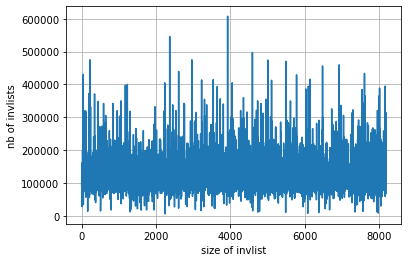

In [28]:
# TODO: debug this
# Show size Distribution of all cells (inverted lists)
# print([invlists.list_size(l) for l in range(invlists.nlist)])
# bc = np.bincount([invlists.list_size(l) for l in range(invlists.nlist)])
# pyplot.step(np.arange(bc.size), bc)
bc = [invlists.list_size(l) for l in range(invlists.nlist)]
pyplot.step(np.arange(len(bc)), bc)
pyplot.xlabel('size of invlist')
pyplot.ylabel('nb of invlists')
pyplot.grid()

In [29]:
"""
Self-implemented functions to search a query vectors
"""

def distance_full_vec(v1, v2):
    """Given 2 full vector, return their L2 distance"""
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    dist = np.sum(v_diff * v_diff)
    return dist

def construct_distance_table(q_res, sub_cen):
    """
    q_res: a full precision query vector, shape = (d, ), e.g., (128, )
    sub_cen: sub-quantizer center, shape = (m, 256, d / m), e.g., d=128, m=16 -> (16, 256, 8)
    """
    M, ksub, dsub = sub_cen.shape
    dist_table = np.zeros(shape=(M, ksub))
    
    for m in range(M):
        q_res_part = q_res[m * dsub: (m + 1) * dsub]
        for k in range(ksub):
            PQ_cent = sub_cen[m][k]
            res_dist = PQ_cent - q_res_part
            dist = np.sum(res_dist * res_dist)
            
            dist_table[m, k] = dist
            
    return dist_table

def estimate_distance(pq_code, dist_table):
    """
    given single PQ code and its distance table, compute the estimated distance
    """
    # pq_cen -> (pq.M 8, pq.ksub 256, pq.dsub D/M=64/8=8)
    M = dist_table.shape[0]
    assert M == len(pq_code)
    
    dist = 0
    for m in range(M):
        dist += dist_table[m][pq_code[m]]
        
    return dist

def estimate_distances(vec_ids, pq_codes, dist_table):
    """
    A wrapper of "estimate_distance", estimating the distance of a batch
      of PQ codes
    vec_ids, pq_codes: get_invlist(invlists, closest_cell)
    center_dist: the distance from query vector to the coarse-grained
      cluster centroid.
      
    Return: an sorted list of pair (vec_id, distance)
       [(vec0, dist0), ... (vecN, distN)]
    """
    assert len(vec_ids) == len(pq_codes)
    vec_dist_list = []
    
    for i in range(len(vec_ids)):
        pq_code = pq_codes[i]
        vec_id = vec_ids[i]
        dist = estimate_distance(pq_code, dist_table)# + center_dist
        vec_dist_list.append((vec_id, dist))
        
    vec_dist_list.sort(key=lambda x:x[1])
    
    return vec_dist_list

def search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen):
    """
    Search a single query vector, shape = (d, )
    """
    
    # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])

    # Estimate distance by ADC
    closest_cell_list = coarse_dist_ls[:nprobe]
    vec_dist_id_list = []
    for cell in closest_cell_list:
        cell_id = cell[1]
        center_dist = cell[0]
        list_ids, list_codes = get_invlist(invlists, cell_id)
        q_res = q_vec - coarse_cen[cell_id]
        # Note! store sub-quantizer once, but the number of compute = nprobe 
        dist_table = construct_distance_table(q_res, sub_cen)
        vec_dist_id_list_single_cell = estimate_distances(list_ids, list_codes, dist_table)
        vec_dist_id_list += vec_dist_id_list_single_cell
        
    vec_dist_id_list.sort(key=lambda x:x[1])
    vec_dist_id_list = vec_dist_id_list[:topk]
    id_list = [pair[0] for pair in vec_dist_id_list]
    dist_list = [pair[1] for pair in vec_dist_id_list]
    
    return id_list, dist_list

def search_batch_query(q_vecs, nprobe, topk, coarse_cen, sub_cen):
    """
    The wrapper of "search_single_query", search a batch of vectors
    input: q_vecs shape -> (batch_size, d)
    """
    id_list_batch = []
    dist_list_batch = []
    for q_vec in q_vecs:
        id_list, dist_list = search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen)
        id_list_batch.append(id_list)
        dist_list_batch.append(dist_list)
        
    return id_list_batch, dist_list_batch

In [30]:
print(single_q.shape)
my_single_q = single_q.reshape((d, ))
print(my_single_q.shape)

(1, 128)
(128,)


In [31]:
nprobe = 32
topk = 100

### Faiss query shape: (10000, 128)

id_list, dist_list = search_single_query(my_single_q, nprobe, topk, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(id_list))
print("==== Distances ====\n\n{}\n".format(dist_list))

==== Vector IDs ====

[672303393, 615142927, 204071725, 971823307, 201892784, 937541801, 722477532, 336118969, 245885573, 740285375, 656556888, 968173533, 110973576, 277259885, 290543557, 203588195, 544978851, 614757093, 904249396, 207753439, 458731394, 267986685, 880358133, 123365395, 725237737, 221456167, 383328762, 351655146, 862245159, 634040555, 668882806, 744707409, 718496051, 203398697, 956349545, 879095196, 674980795, 356698977, 657676309, 920763800, 168233858, 470132504, 366729519, 255829277, 339763325, 250663892, 40642738, 722321159, 791883084, 694293478, 28539420, 302873886, 794816190, 481248571, 351657336, 221457391, 822165807, 681475806, 579811330, 716055137, 704361214, 477723287, 922453899, 178577649, 837625153, 502889241, 776920366, 648108651, 591351597, 558889020, 876033653, 40156538, 224060326, 71522777, 956646244, 148931760, 31464083, 221456488, 261944447, 219498491, 372047056, 731202344, 536916168, 459020955, 944547995, 991250886, 219151745, 833801070, 785731029, 207

In [32]:
print("ID Correct? ", np.allclose(id_list, idx))
print("Distance Correct? ", np.allclose(dist_list, dist))

ID Correct?  True
Distance Correct?  True


In [33]:
"""
Faiss Result:
==== Index ====

[[672303393 615142927 204071725 971823307 201892784 937541801 722477532
  336118969 245885573 740285375 656556888 968173533 110973576 277259885
  290543557 203588195 544978851 614757093 904249396 207753439 458731394
  267986685 880358133 123365395 725237737 221456167 383328762 351655146
  862245159 634040555 668882806 744707409 718496051 203398697 956349545
  879095196 674980795 356698977 657676309 920763800 168233858 470132504
  366729519 255829277 339763325 250663892  40642738 722321159 791883084
  694293478  28539420 302873886 794816190 481248571 351657336 221457391
  822165807 681475806 579811330 716055137 704361214 477723287 922453899
  178577649 837625153 502889241 776920366 648108651 591351597 558889020
  876033653  40156538 224060326  71522777 956646244 148931760  31464083
  221456488 261944447 219498491 372047056 731202344 536916168 459020955
  944547995 991250886 219151745 833801070 785731029 207488404 768782587
  221457012 879095218 468300062 967679308 622011351 542891735 905142920
  277061603 603696095]]

==== Distance ====

[[50993.312 54336.492 56335.69  56883.074 57609.645 58113.477 58424.234
  58844.266 59015.65  59083.246 59254.414 59307.22  59382.55  59646.51
  59875.91  59983.35  59994.895 60362.39  60540.477 60558.508 60612.168
  60828.188 61009.992 61100.28  61355.945 61508.836 61599.242 61678.324
  61820.758 61864.773 61877.14  61931.05  62144.586 62155.523 62502.434
  62640.95  62709.465 62710.11  62730.77  62820.934 62844.51  62854.613
  62868.47  62945.246 62998.51  63150.598 63253.37  63259.08  63282.508
  63334.664 63354.035 63378.207 63432.15  63457.707 63461.918 63493.742
  63507.29  63516.586 63563.277 63591.62  63674.47  63675.26  63798.09
  63808.58  63819.746 63837.188 63914.13  63975.824 63985.883 64046.8
  64063.17  64101.348 64147.957 64155.215 64168.44  64207.184 64269.01
  64308.76  64358.62  64423.93  64536.383 64551.13  64581.7   64584.312
  64683.51  64710.33  64728.1   64787.99  64805.87  64837.395 64871.25
  64871.598 64879.473 64940.348 64965.21  64986.85  65010.22  65039.09
  65092.47  65136.492]]
"""

'\nFaiss Result:\n==== Index ====\n\n[[672303393 615142927 204071725 971823307 201892784 937541801 722477532\n  336118969 245885573 740285375 656556888 968173533 110973576 277259885\n  290543557 203588195 544978851 614757093 904249396 207753439 458731394\n  267986685 880358133 123365395 725237737 221456167 383328762 351655146\n  862245159 634040555 668882806 744707409 718496051 203398697 956349545\n  879095196 674980795 356698977 657676309 920763800 168233858 470132504\n  366729519 255829277 339763325 250663892  40642738 722321159 791883084\n  694293478  28539420 302873886 794816190 481248571 351657336 221457391\n  822165807 681475806 579811330 716055137 704361214 477723287 922453899\n  178577649 837625153 502889241 776920366 648108651 591351597 558889020\n  876033653  40156538 224060326  71522777 956646244 148931760  31464083\n  221456488 261944447 219498491 372047056 731202344 536916168 459020955\n  944547995 991250886 219151745 833801070 785731029 207488404 768782587\n  221457012 87

In [34]:
"""
Verify the correctness of a batch of query vectors
"""
print("all queries: ", xq.shape)
batch_size = 32
my_multi_q = xq[:batch_size]
print("my_multi_q: ", my_multi_q.shape)
print("single vector in my_multi_q:", my_multi_q[0].shape)

all queries:  (10000, 128)
my_multi_q:  (32, 128)
single vector in my_multi_q: (128,)


In [32]:
"""Batch Version"""
id_list, dist_list = search_batch_query(my_multi_q, nprobe, topk, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(id_list))
print("==== Distances ====\n\n{}\n".format(dist_list))

==== Vector IDs ====

[[672303393, 615142927, 204071725, 971823307, 201892784, 937541801, 722477532, 336118969, 245885573, 740285375, 656556888, 968173533, 110973576, 277259885, 290543557, 203588195, 544978851, 614757093, 904249396, 207753439, 458731394, 267986685, 880358133, 123365395, 725237737, 221456167, 383328762, 351655146, 862245159, 634040555, 668882806, 744707409, 718496051, 203398697, 956349545, 879095196, 674980795, 356698977, 657676309, 920763800, 168233858, 470132504, 366729519, 255829277, 339763325, 250663892, 40642738, 722321159, 791883084, 694293478, 28539420, 302873886, 794816190, 481248571, 351657336, 221457391, 822165807, 681475806, 579811330, 716055137, 704361214, 477723287, 922453899, 178577649, 837625153, 502889241, 776920366, 648108651, 591351597, 558889020, 876033653, 40156538, 224060326, 71522777, 956646244, 148931760, 31464083, 221456488, 261944447, 219498491, 372047056, 731202344, 536916168, 459020955, 944547995, 991250886, 219151745, 833801070, 785731029, 20

In [40]:
# Faiss result for 10000 items: D, I
faiss_D = D[:batch_size]
faiss_I = I[:batch_size]
for i in range(batch_size):
    print("i = {}\tID Correct? {}".format(i, np.allclose(id_list[i], faiss_I[i], rtol=1e-02, atol=10)))
          
print("ID Correct? ", np.allclose(id_list, faiss_I, rtol=1e-02, atol=10))
print("Distance Correct? ", np.allclose(dist_list, faiss_D))

i = 0	ID Correct? True
i = 1	ID Correct? True
i = 2	ID Correct? True
i = 3	ID Correct? True
i = 4	ID Correct? True
i = 5	ID Correct? False
i = 6	ID Correct? True
i = 7	ID Correct? True
i = 8	ID Correct? True
i = 9	ID Correct? True
i = 10	ID Correct? True
i = 11	ID Correct? True
i = 12	ID Correct? True
i = 13	ID Correct? True
i = 14	ID Correct? True
i = 15	ID Correct? True
i = 16	ID Correct? True
i = 17	ID Correct? True
i = 18	ID Correct? False
i = 19	ID Correct? True
i = 20	ID Correct? True
i = 21	ID Correct? True
i = 22	ID Correct? True
i = 23	ID Correct? True
i = 24	ID Correct? True
i = 25	ID Correct? False
i = 26	ID Correct? True
i = 27	ID Correct? True
i = 28	ID Correct? True
i = 29	ID Correct? True
i = 30	ID Correct? True
i = 31	ID Correct? True
ID Correct?  False
Distance Correct?  False


In [51]:
"""
This sort of error has no problem, just because of the computation precision, 
e.g.
i = 34	my result: 651781686	faiss result:186994121
i = 35	my result: 186994121	faiss result:651781686
"""
error_query_id = 25
for i in range(topk):
    if id_list[error_query_id][i] != faiss_I[error_query_id][i]:
        print("i = {}\tmy result: {}\tfaiss result:{}".format(
            i, id_list[error_query_id][i], faiss_I[error_query_id][i]))

i = 94	my result: 98539638	faiss result:905529872
i = 95	my result: 905529872	faiss result:98539638


In [35]:
"""
Functions to get the debugging information for node 1:
    cell IDs that should be searched (nprobe)
    the center distance between the query vector and those cells
    the distance table constructed for each cell
"""

def get_node0_info_single_query(q_vec, nprobe, coarse_cen, sub_cen):
    """
    Given a batch of query vectors
    Return:
        the cell IDs that should be searched
        the center distance between the query vector and those cells
        the distance table constructed for each cell, shape=(M, ksub)
    input: q_vecs shape -> (batch_size, d)
    """
    
    # dist_table = np.zeros()
        # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])
    cell_ids = [cd[1] for cd in coarse_dist_ls][:nprobe]
    cell_dists = [cd[0] for cd in coarse_dist_ls][:nprobe]
    dist_tables = []
    
    closest_cell_list = coarse_dist_ls[:nprobe]
    for cell in closest_cell_list:
        cell_id = cell[1]
        q_res = q_vec - coarse_cen[cell_id]
        dist_table = construct_distance_table(q_res, sub_cen)
        dist_tables.append(dist_table)
    
    return cell_ids, cell_dists, dist_tables


def get_node0_info_batch_query(q_vecs, nprobe, coarse_cen, sub_cen):
    """
    The wrapper of "get_node0_info_single_query", search a batch of vectors
    input: q_vecs shape -> (batch_size, d)
    Return: 
        cell_ids_batch: list of list, shape = (batch_size, nprobe)
        cell_dists_batch: list of list, shape = (batch_size, nprobe)
        dist_tables: nested list, shape = (batch_size, nprobe, (M, ksub))
            each element is an np array of shape (M, ksub)
    """
    cell_ids_batch = [] 
    cell_dists_batch = [] 
    dist_tables_batch = []
    for q_vec in q_vecs:
        cell_ids, cell_dists, dist_tables = \
            get_node0_info_single_query(q_vec, nprobe, coarse_cen, sub_cen)
        cell_ids_batch.append(cell_ids)
        cell_dists_batch.append(cell_dists)
        dist_tables_batch.append(dist_tables)
        
    return cell_ids_batch, cell_dists_batch, dist_tables_batch

In [36]:
cell_ids, cell_dists, dist_tables = \
    get_node0_info_single_query(my_single_q, nprobe, coarse_cen, sub_cen)

In [37]:
print("Cell ids:\n{}\n".format(cell_ids))
print("Cell distances:\n{}\n".format(cell_dists))
print("Distance Tables:\nlen: {}\nshape of each element: {}\n".format(len(dist_tables), dist_tables[0].shape))
print("Sample Distance Table:\n{}\n".format(dist_tables[0]))

Cell ids:
[4121, 3860, 4300, 1058, 1787, 4257, 248, 4861, 2883, 2856, 3890, 494, 6522, 1211, 7419, 6119, 132, 6288, 455, 7196, 6448, 3351, 1741, 6323, 7233, 3389, 6776, 7171, 3448, 2742, 2458, 5387]

Cell distances:
[71414.47, 71604.61, 72159.05, 72904.22, 73240.64, 74403.83, 76753.69, 79598.24, 81912.64, 82047.98, 83197.89, 84027.14, 84515.89, 85231.266, 86173.06, 86581.38, 87116.695, 87167.7, 87184.2, 87758.95, 87929.266, 87974.33, 88263.78, 88283.66, 88321.09, 88603.34, 88862.984, 88873.734, 89499.625, 89657.016, 89919.484, 90270.76]

Distance Tables:
len: 32
shape of each element: (16, 256)

Sample Distance Table:
[[19250.63867188  6771.10742188  2142.56591797 ... 10111.23339844
   5567.69726562  6488.74511719]
 [14268.57714844  2025.87194824  7582.63085938 ... 15705.42773438
  12283.08007812 12067.70117188]
 [ 3969.4128418   3256.88647461  3567.9699707  ... 14188.60742188
   4356.26025391  1646.32348633]
 ...
 [ 6585.92236328  6152.34765625  5013.48779297 ... 18925.0625
   5484.88

In [54]:
# my_multi_q batch size = 64
batch_size = 64
my_multi_q = xq[:batch_size]
cell_ids_batch, cell_dists_batch, dist_tables_batch = \
    get_node0_info_batch_query(my_multi_q, nprobe, coarse_cen, sub_cen)

In [55]:
dist_tables_batch_reshape = []
for i in range(len(dist_tables_batch)):
    dist_tables_batch_reshape.append([])
    for j in range(len(dist_tables_batch[0])):
        table = np.zeros(shape=(256, 16), dtype=np.float32)
        for m in range(16):
            for n in range(256):
                table[n][m] = dist_tables_batch[i][j][m][n]
        dist_tables_batch_reshape[i].append(table)

In [56]:
dist_tables_batch_reshape = np.array(dist_tables_batch_reshape, dtype=np.float32)
print("dist_tables_batch_reshape:\n\nshape:{}\nvalue: {}\n".format(
    dist_tables_batch_reshape.shape, dist_tables_batch_reshape))

dist_tables_batch_reshape:

shape:(64, 32, 256, 16)
value: [[[[19250.639   14268.577    3969.4128  ...  6585.9224   6474.6904
     1073.1978 ]
   [ 6771.1074   2025.872    3256.8865  ...  6152.3477   4997.516
     2141.3613 ]
   [ 2142.566    7582.631    3567.97    ...  5013.488    5631.1865
     3192.1895 ]
   ...
   [10111.233   15705.428   14188.607   ... 18925.062   13556.436
    14815.798  ]
   [ 5567.6973  12283.08     4356.2603  ...  5484.885   19919.1
    11719.885  ]
   [ 6488.745   12067.701    1646.3235  ... 25901.172   15219.779
    14570.749  ]]

  [[17006.178   17409.895    5790.5874  ...  7101.9155   7089.0566
     2698.6372 ]
   [ 5627.377    3845.169    6298.62    ...  5977.161    5565.8105
     1787.9036 ]
   [ 1420.6523  10374.975    7526.904   ...  7128.6367   6752.617
      858.7821 ]
   ...
   [ 7418.4336  20531.162   17155.645   ... 13700.301   13458.075
    16447.36   ]
   [ 4492.631   17285.896    6434.3525  ...  4811.37    20651.668
    10088.55   ]
   [ 4287.

In [59]:
print("Shape of cell_ids_batch:\nfirst dimension (batch_size): {}\nsecond dimension(nprobe): {}\n".format(
    len(cell_ids_batch), len(cell_ids_batch[0])))
print("Shape of cell_dists_batch:\nfirst dimension (batch_size): {}\nsecond dimension(nprobe): {}\n".format(
    len(cell_dists_batch), len(cell_dists_batch[0])))
print("Shape of dist_tables_batch:\nfirst dimension (batch_size): {}\nsecond dimension (nprobe): {}\neach element (M, ksub): {}\n".format(
    len(dist_tables_batch), len(dist_tables_batch[0]), dist_tables_batch[0][0].shape))
      

Shape of cell_ids_batch:
first dimension (batch_size): 64
second dimension(nprobe): 32

Shape of cell_dists_batch:
first dimension (batch_size): 64
second dimension(nprobe): 32

Shape of dist_tables_batch:
first dimension (batch_size): 64
second dimension (nprobe): 32
each element (M, ksub): (16, 256)



In [60]:
"""
Save these debugging information as np arrays
"""
np_cell_ids_batch = np.array(cell_ids_batch, dtype=np.int32).reshape(batch_size, nprobe)
np_cell_dists_batch = np.array(cell_dists_batch, dtype=np.float32).reshape(batch_size, nprobe)
m, ksub = dist_tables_batch[0][0].shape
assert m == 16 and ksub == 256
np_dist_tables_batch = np.array(dist_tables_batch, dtype=np.float32).reshape(batch_size, nprobe, m, ksub)

In [61]:
# assert this form conversion is correct
for i in range(batch_size):
    for j in range(nprobe):
        assert np_cell_ids_batch[i][j] == cell_ids_batch[i][j] 
        assert np_cell_dists_batch[i][j] == cell_dists_batch[i][j] 
        for k in range(m):
            for l in range(ksub):
                assert np_dist_tables_batch[i][j][k][l] == dist_tables_batch[i][j][k][l]

In [42]:
np.save("./node0_info/np_cell_ids_batch.npy", np_cell_ids_batch)
np.save("./node0_info/np_cell_dists_batch.npy", np_cell_dists_batch)
np.save("./node0_info/np_dist_tables_batch.npy", np_dist_tables_batch)

In [43]:
load_np_cell_ids_batch = np.load("./node0_info/np_cell_ids_batch.npy")
load_np_cell_dists_batch = np.load("./node0_info/np_cell_dists_batch.npy")
load_np_dist_tables_batch = np.load("./node0_info/np_dist_tables_batch.npy")

print(np.allclose(load_np_cell_ids_batch, np_cell_ids_batch))
print(np.allclose(load_np_cell_dists_batch, np_cell_dists_batch))
print(np.allclose(load_np_dist_tables_batch, np_dist_tables_batch))

True
True
True


In [63]:
"""NOTE! Don't run this unless you want to save them to npy"""
if save_data == True:
    debug_searched_cell_ids = np.array(np_cell_ids_batch, dtype=np.int32)
    debug_searched_cell_dist = np.array(np_cell_dists_batch, dtype=np.float32)
    debug_dist_table = np.array(dist_tables_batch_reshape, dtype=np.float32)
    print(debug_searched_cell_ids.shape, debug_searched_cell_dist.shape, debug_dist_table.shape)
    debug_searched_cell_ids.tofile(
        "./saved_npy_data/debug_searched_cell_ids_int32_batch_size_64_nprobe_32_raw")
    debug_searched_cell_dist.tofile(
        "./saved_npy_data/debug_searched_cell_dist_float32_batch_size_64_nprobe_32_raw")
    debug_dist_table.tofile(
        "./saved_npy_data/debug_dist_table_float32_batch_size_64_nprobe_32_K_256_M_16_raw")

(64, 32) (64, 32) (64, 32, 256, 16)


In [ ]:
""" Unused """
def get_single_query_searched_cell_id_and_dist_table(q_vec, nprobe, topk, coarse_cen, sub_cen):
    """
    Search a single query vector, shape = (d, )
    """
    
    # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])

    # Estimate distance by ADC
    closest_cell_list = coarse_dist_ls[:nprobe]
    dist_table_list = []
    
    for cell in closest_cell_list:
        cell_id = cell[1]
        center_dist = cell[0]
        list_ids, list_codes = get_invlist(invlists, cell_id)
        q_res = q_vec - coarse_cen[cell_id]
        # Note! store sub-quantizer once, but the number of compute = nprobe 
        dist_table = construct_distance_table(q_res, sub_cen)
        dist_table_list.append(dist_table)
    
    searched_cell_id_list = closest_cell_list
    return searched_cell_id_list, dist_table_list

def get_batch_query_searched_cell_id_and_dist_table(q_vecs, nprobe, topk, coarse_cen, sub_cen):
    """
    The wrapper of "search_single_query", search a batch of vectors
    input: q_vecs shape -> (batch_size, d)
    """
    searched_cell_id_list_batch = []
    dist_table_list_batch = []
    for q_vec in q_vecs:
        searched_cell_id_list, dist_table_list = get_single_query_searched_cell_id_and_dist_table(q_vec, nprobe, topk, coarse_cen, sub_cen)
        searched_cell_id_list_batch.append(searched_cell_id_list)
        dist_table_list_batch.append(dist_table_list)
        
    return searched_cell_id_list_batch, dist_table_list_batch